In [1]:
import transformers
import os
import pickle
import numpy as np
from transformers import convert_bert_original_tf_checkpoint_to_pytorch
from transformers import BertTokenizer, BertModel, BertForMaskedLM, BertForQuestionAnswering, BertForPreTraining

In [2]:
import torch.nn as nn
import torch.functional as F
import torch

## Load bert

In [3]:
# BERT_MODEL_PATH = "rubert/"
# os.listdir(BERT_MODEL_PATH)

In [4]:
# convert_bert_original_tf_checkpoint_to_pytorch.convert_tf_checkpoint_to_pytorch(
#     BERT_MODEL_PATH + 'bert_model.ckpt',
# BERT_MODEL_PATH + 'bert_config.json','pytorch_model.bin')

In [5]:
model_path = "rubert_pytorch/"

In [6]:
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertModel.from_pretrained(model_path);

INFO:transformers.tokenization_utils:Model name 'rubert_pytorch/' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese, bert-base-german-cased, bert-large-uncased-whole-word-masking, bert-large-cased-whole-word-masking, bert-large-uncased-whole-word-masking-finetuned-squad, bert-large-cased-whole-word-masking-finetuned-squad, bert-base-cased-finetuned-mrpc). Assuming 'rubert_pytorch/' is a path or url to a directory containing tokenizer files.
INFO:transformers.tokenization_utils:Didn't find file rubert_pytorch/added_tokens.json. We won't load it.
INFO:transformers.tokenization_utils:Didn't find file rubert_pytorch/special_tokens_map.json. We won't load it.
INFO:transformers.tokenization_utils:Didn't find file rubert_pytorch/tokenizer_config.json. We won't load it.
INFO:transformers.tokenization_utils:loading file rubert_pytorch/vocab.txt
INFO:tran

## Load data 

In [7]:
story_path = "story_data.pkl"
with open(story_path, 'rb') as f:
    data = pickle.load(f)

In [8]:
new = data[:400]

In [9]:
data_flat = np.concatenate(new, 0)

In [10]:
data_flat = list(map(str.lower, data_flat))

## Data preprocessing 

In [11]:
trigrams = [([data_flat[i], data_flat[i + 1]], data_flat[i + 2])
            for i in range(len(data_flat) - 2)]
chunk_len=len(trigrams)
print(trigrams[:3])

[(['п19', 'как'], 'дурачок'), (['как', 'дурачок'], 'поехал'), (['дурачок', 'поехал'], 'к')]


In [12]:
vocab = set(data_flat)
voc_len=len(vocab)
word_to_ix = {word: i for i, word in enumerate(vocab)}

In [13]:
inp=[]
tar=[]
for context, target in trigrams:
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
        inp.append(context_idxs)
        targ = torch.tensor([word_to_ix[target]], dtype=torch.long)
        tar.append(targ)

## Init Language Model 

In [14]:
def get_bert_embed_matrix(model):
    
    bert_embeddings = list(model.children())[0]
    bert_word_embeddings = list(bert_embeddings.children())[0]
    mat = bert_word_embeddings.weight.data.numpy()
    return torch.tensor(mat)

In [15]:
matrix = get_bert_embed_matrix(model)

In [16]:
def create_emb_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = weights_matrix.size()
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

In [17]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
#         self.encoder, input_size, hidden_size = create_emb_layer(matrix, True)

        self.gru = nn.GRU(hidden_size*2, hidden_size, n_layers, batch_first=True,
                          bidirectional=False)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [18]:
def train(inp, target):
    hidden = decoder.init_hidden().cuda()
    decoder.zero_grad()
    loss = 0
    
    for c in range(chunk_len):
        output, hidden = decoder(inp[c].cuda(), hidden)
        loss += criterion(output, target[c].cuda())

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

In [19]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [20]:
train_on_gpu = torch.cuda.is_available()

In [35]:
n_epochs = 80
print_every = 1
plot_every = 4
hidden_size = 120
n_layers = 1
lr = 0.015

decoder = RNN(voc_len, hidden_size, voc_len, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0
if(train_on_gpu):
    decoder.cuda()
for epoch in range(1, n_epochs + 1):
    loss = train(inp,tar)       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 15s (1 0%) 8.1147]
 30s (2 0%) 7.6463]
 45s (3 0%) 7.0041]
 0s (4 0%) 6.3052]
 15s (5 0%) 5.7327]
 31s (6 0%) 5.2069]
 46s (7 0%) 4.6993]
 1s (8 0%) 4.1808]
 16s (9 0%) 3.6588]
 31s (10 0%) 3.1496]
 46s (11 0%) 2.6804]
 1s (12 0%) 2.2705]
 16s (13 0%) 1.9168]
 31s (14 0%) 1.6125]
 47s (15 0%) 1.3502]
 2s (16 0%) 1.1244]
 17s (17 0%) 0.9319]
 32s (18 0%) 0.7681]
 47s (19 0%) 0.6303]
 2s (20 0%) 0.5153]
 17s (21 0%) 0.4194]
 32s (22 0%) 0.3402]
 47s (23 0%) 0.2754]
 3s (24 0%) 0.2227]
 18s (25 0%) 0.1804]
 33s (26 0%) 0.1464]
 48s (27 0%) 0.1191]
 3s (28 0%) 0.0973]
 18s (29 0%) 0.0800]
 33s (30 0%) 0.0662]
 48s (31 0%) 0.0552]
 3s (32 0%) 0.0463]
 18s (33 0%) 0.0392]
 34s (34 0%) 0.0333]
 49s (35 0%) 0.0286]
 4s (36 0%) 0.0248]
 19s (37 0%) 0.0217]
 34s (38 0%) 0.0192]
 49s (39 0%) 0.0172]
 4s (40 0%) 0.0154]
 19s (41 0%) 0.0140]
 34s (42 0%) 0.0127]
 49s (43 0%) 0.0117]
 5s (44 0%) 0.0108]
 20s (45 0%) 0.0100]
 35s (46 0%) 0.0094]
 50s (47 0%) 0.0088]
 5s (48 0%) 0.0082]
 20s (49 0%) 

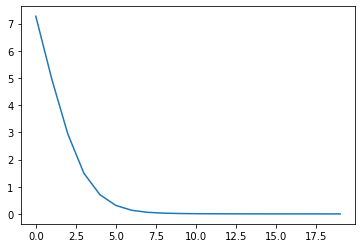

In [36]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [37]:
def evaluate(prime_str, predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden().cuda()

    for p in range(predict_len):
        
        prime_input = torch.tensor([word_to_ix[w] for w in prime_str.split()], dtype=torch.long).cuda()
        inp = prime_input[-2:] 
        output, hidden = decoder(inp, hidden)
        
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        predicted_word = list(word_to_ix.keys())[list(word_to_ix.values()).index(top_i)]
        prime_str += " " + predicted_word
#         inp = torch.tensor(word_to_ix[predicted_word], dtype=torch.long)

    return prime_str

In [67]:
print(evaluate('друг купил', 16, temperature=1))

друг купил две шавы и заскринил оплату теперь ходим и покупаем шаурму по скрину включаем дурочку делаем так
